# Creating features dataset

## Imports

In [1]:
import os, shutil
from pathlib import Path
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

from transformers import Wav2Vec2Processor, Wav2Vec2Model

## Uploading data_utils

In [2]:
from google.colab import files
files.upload()

Saving data_utils.py to data_utils.py


{'data_utils.py': b'"""data_utils.py - minimal DEAM helper, robust audio-folder discovery\r\n\r\nExample\r\n-------\r\n    from data_utils import DEAMHandler\r\n    handler = DEAMHandler()\r\n    y, sr = handler.get_waveform(23)\r\n"""\r\n\r\nfrom __future__ import annotations\r\n\r\nimport os\r\nimport pandas as pd\r\nimport kagglehub\r\nimport librosa\r\nimport torch\r\nfrom torch.utils.data import Dataset\r\n\r\n\r\n\r\n__all__ = ["DEAMHandler"]\r\n\r\n\r\nclass DEAMHandler:\r\n    """Download DEAM via KaggleHub, load annotations, locate audio, serve waveforms."""\r\n\r\n    _KAGGLE_ID = "imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music"\r\n\r\n    _STATIC_CSV = (\r\n        "DEAM_Annotations/annotations/annotations averaged per song/"\r\n        "song_level/static_annotations_averaged_songs_1_2000.csv"\r\n    )\r\n    _DYN_AROUSAL_CSV = (\r\n        "DEAM_Annotations/annotations/annotations averaged per song/"\r\n        "dynamic (per second annotations)/arousal.csv"\r\n

## Configuration

In [3]:
MODEL_NAME = "ALM/wav2vec2-base-audioset"
TARGET_SR  = 16_000
LAYER_IDX  = 10                          # take hidden_states[10]
BATCH_SIZE = 8
DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'
DIR        = Path("DEAM_feats")
OUT_DIR    = Path(f"{DIR}/songs")    # feats_utils except this

## Loading the DEAM dataset

In [4]:
from data_utils import DEAMHandler

# Load DEAM
handler = DEAMHandler()
present_ids = sorted(handler.static_annotations["song_id"].tolist())
len(present_ids), present_ids[:5]

Dataset root: /kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music
Audio directory: /kaggle/input/deam-mediaeval-dataset-emotional-analysis-in-music/DEAM_audio/MEMD_audio

Dataset Preview:
   song_id  valence_mean  valence_std  arousal_mean  arousal_std
0        2           3.1         0.94           3.0         0.63
1        3           3.5         1.75           3.3         1.62
2        4           5.7         1.42           5.5         1.63
3        5           4.4         2.01           5.3         1.85
4        7           5.8         1.47           6.4         1.69

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   song_id       1744 non-null   int64  
 1   valence_mean  1744 non-null   float64
 2   valence_std   1744 non-null   float64
 3   arousal_mean  1744 non-null   float64
 4   arousal_std   1744 non-nu

(1744, [2, 3, 4, 5, 7])

## Creating directory for embeddings

In [5]:
!mkdir -p DEAM_feats/songs

Loading the model

In [6]:
# Wav2Vec2 setup
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
model = Wav2Vec2Model.from_pretrained(MODEL_NAME, output_hidden_states=True).to(DEVICE)
model.eval()
for p in model.parameters():
    p.requires_grad_(False)
print("Model on", DEVICE)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/606 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/358 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Model on cuda


## forward on all songs (only 10 first layers)

In [7]:
def forward_full_song(wave_1d: torch.Tensor, sr: int):
    """Run entire song through W2V2; returns [T, D] hidden states at LAYER_IDX."""
    with torch.no_grad():
        inputs = processor([wave_1d.numpy()], sampling_rate=sr, return_tensors='pt', padding=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        out = model(**inputs)
        h = out.hidden_states[LAYER_IDX].squeeze(0)  # [T, D]
        return h.detach().cpu()

def extract_song_embeddings_full(song_id: int):
    wav_np, sr = handler.get_waveform(song_id, target_sr=TARGET_SR, mono=True)
    wav = torch.tensor(wav_np, dtype=torch.float)
    seq = forward_full_song(wav, sr)   # raises if OOM or anything else
    return seq

def save_song_embeddings(song_id: int, seq: torch.Tensor):
    out_path = OUT_DIR / f"{int(song_id)}.pt"
    torch.save(seq.float(), out_path)
    return out_path

In [8]:
 # Run over all songs
for sid in tqdm(present_ids, desc='Extracting (full-song)'):
    out_file = OUT_DIR / f"{int(sid):04d}.pt"
    if out_file.exists():
        continue
    seq = extract_song_embeddings_full(sid)
    save_song_embeddings(sid, seq)
print('Done.')


Extracting (full-song):   0%|          | 0/1744 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Done.


## Placing the annotation file as excepted by feats_utils

In [10]:
csv_out = f"{DIR}/annotations.csv"

handler.static_annotations.to_csv(csv_out, index=False)

print(f"Saved static annotations to:\n   {csv_out}")

Saved static annotations to:
   DEAM_feats/annotations.csv


# Model

## Imports

In [11]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, Wav2Vec2Processor
import kagglehub
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Wav2Vec2Model
# from transformers import get_linear_schedule_with_warmup
# from transformers.optimization import get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import CyclicLR
from torch.optim import AdamW
from tqdm import tqdm, trange
import os

## Uploading data_utils_feats.py

In [12]:
from google.colab import files
files.upload()

Saving data_utils_feats.py to data_utils_feats.py


{'data_utils_feats.py': b'# data_utils_feats.py\r\nfrom __future__ import annotations\r\n\r\nimport os, torch\r\nimport pandas as pd\r\nfrom torch.utils.data import Dataset, DataLoader\r\nfrom torch.nn.utils.rnn import pad_sequence\r\nfrom sklearn.model_selection import train_test_split\r\n\r\n__all__ = ["DEAMFeatHandler", "FeatDataset", "feat_collate"]\r\n\r\n# \xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80 Dataset \xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\xe2\x94\x80\r

## Model Training

### Loading and Saving Helpers

In [13]:
CKPT_PATH = "best_top2_model.pt"

def load_ckpt():
    """
    Attempts to load model, optimizer, scheduler state dicts.
    On failure, deletes the checkpoint and returns 0 to start fresh.
    Returns the last completed epoch (so training will resume at epoch).
    """
    if not os.path.exists(CKPT_PATH):
        print("→ no previous checkpoint — starting fresh")
        return 0

    try:
        ckpt = torch.load(CKPT_PATH, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt.get("optimizer_state_dict", {}))
        scheduler.load_state_dict(ckpt.get("scheduler_state_dict", {}))
        epoch = ckpt.get("epoch", 0)
        print(f"→ Loaded checkpoint '{CKPT_PATH}' (epoch {epoch})")
        return epoch
    except Exception as e:
        print(f"→ Failed to load checkpoint: {e!r}")
        print(f"→ Deleting corrupt checkpoint and starting fresh")
        os.remove(CKPT_PATH)
        return 0


def save_ckpt(epoch):
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
    }, CKPT_PATH)

### Device

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


### Hyper Parameters

In [123]:
EPOCHS = 20
LR  = 3e-5
MAX_LR = 1e-3  # for cyclic scheduler
BATCH_SIZE = 32
WEIGHT_DECAY = 1e-4
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
LAMBDA_CORR = 0.05  # correlation penalty
LAMBDA_VAR  = 0.05  # variance penalty
GRAD_CLIP = 1.0
WeightLoss = False  # weight the loss to treat imbalance - does not work well
FINETUNE = "last1"   # options: "frozen", "last1", "lastN", "all"

## Data

In [124]:
# feats_root = "/content/drive/MyDrive/Colab Notebooks/DeepProject/DEAM_feats"
feats_root = DIR

print(feats_root)

DEAM_feats


### Getting Data Loaders

In [125]:
from data_utils_feats import DEAMFeatHandler

handler = DEAMFeatHandler(feats_root=feats_root)

train_loader, val_loader, test_loader = handler.build_dataloaders(
    batch_size=BATCH_SIZE,        # adjust to GPU memory
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
)

✔ static annotations : DEAM_feats/annotations.csv
✔ feature root       : DEAM_feats/songs


### Getting Mean and STD of Arousal and Valence

In [126]:
import pandas as pd

# load your annotations
annotation = "annotations.csv"
annotation_path = os.path.join(feats_root, annotation)
static_df = pd.read_csv(annotation_path)

# trim leading/trailing spaces from the column names
static_df.columns = static_df.columns.str.strip()

# collect the IDs of training and validation sets
train_ids = train_loader.dataset.ids
val_ids   = val_loader.dataset.ids
train_val_ids = set(train_ids) | set(val_ids)

# filter to only those songs
train_val_df = static_df[static_df['song_id'].isin(train_val_ids)]

# extract the per-song mean columns
vals = train_val_df[['valence_mean','arousal_mean']].values

# compute the global mean and std of those per-song means
valence_mean, arousal_mean = vals.mean(axis=0)
valence_std,   arousal_std   = vals.std(axis=0)

print(f"Valence  μ={valence_mean:.4f}, σ={valence_std:.4f}")
print(f"Arousal  μ={arousal_mean:.4f}, σ={arousal_std:.4f}")

# build the normalization tensors
means = torch.tensor([valence_mean, arousal_mean],
                           dtype=torch.float, device=device)
stds  = torch.tensor([valence_std,   arousal_std],
                           dtype=torch.float, device=device)


Valence  μ=4.9041, σ=1.1754
Arousal  μ=4.8185, σ=1.2943


### Model

In [127]:
def print_parameter_count(model):
    """
    Print the number of parameters in each layer of the model and the total number of parameters.
    """
    total_params = 0
    total_trainable_params = 0
    print(f"\n{'Name':55} | {'Shape':15} | {'Parameters':10} | {'Status'}")
    print("-" * 60)

    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        status = "Trainable" if param.requires_grad else "Frozen"
        if param.requires_grad:
            total_trainable_params += param_count
        print(f"{name:55} | {str(tuple(param.shape)):15} | {param_count:10} | {status}")

    print("-" * 60)
    print(f"{'Total Trainable Parameters':55} | {'':15} | {total_trainable_params:,}\n")
    print(f"{'Total Parameters':55} | {'':15} | {total_params:,}")

In [128]:
# model_top_layers.py
from __future__ import annotations
import torch, torch.nn as nn
from transformers import Wav2Vec2Model

model_id  = "ALM/wav2vec2-base-audioset"
num_layers = 2            # how many encoder layers to keep

class Wav2VecTopRegressor(nn.Module):
    """
    Use the last `num_layers` of a pretrained Wav2Vec-2 encoder on top of
    *pre-computed* hidden-state features, and feed the pooled representation
    into two separate regression heads:
        • valence_head → 1 value
        • arousal_head → 1 value
    The forward() returns a tensor [B, 2] ordered as (valence, arousal).
    """

    def __init__(
        self,
        num_layers: int = 2,
        finetune: str = "frozen",     # "frozen" | "last1" | "lastN" | "all"
        out_dim: int = 1,             # 1 scalar per head
        mid_dim1: int = 512,
        mid_dim2: int = 128,
    ):
        super().__init__()

        # Encoder (top N layers only)
        full = Wav2Vec2Model.from_pretrained(model_id)
        enc  = full.encoder
        self.top_layers = nn.ModuleList(enc.layers[-num_layers:])
        self.layer_norm = enc.layer_norm            # final LN
        hidden = full.config.hidden_size            # 768 for base models

        # Two independent heads
        def _make_head():
            return nn.Sequential(
                nn.Linear(hidden, mid_dim1),
                nn.Dropout(0.3),
                nn.LeakyReLU(0.01, inplace=True),
                nn.Linear(mid_dim1, mid_dim2),
                nn.Dropout(0.3),
                nn.LeakyReLU(0.01, inplace=True),
                nn.Linear(mid_dim2, out_dim),
            )

        self.valence_head = _make_head()
        self.arousal_head = _make_head()

        # For convenience when flipping trainability flags
        self.heads = nn.ModuleList([self.valence_head, self.arousal_head])

        # Freeze / un-freeze according to `finetune`
        # start with everything frozen
        for p in self.parameters():
            p.requires_grad = False

        # enable the requested parts
        if finetune == "all":                          # full fine-tuning
            for p in self.parameters():
                p.requires_grad = True

        elif finetune == "last1":                      # only very last layer
            for p in self.top_layers[-1].parameters():
                p.requires_grad = True
            for p in self.layer_norm.parameters():
                p.requires_grad = True
            for p in self.heads.parameters():          # both heads
                p.requires_grad = True

        elif finetune == "lastN":                      # top `num_layers`
            for lyr in self.top_layers:
                for p in lyr.parameters():
                    p.requires_grad = True
            for p in self.layer_norm.parameters():
                p.requires_grad = True
            for p in self.heads.parameters():
                p.requires_grad = True

        elif finetune == "frozen":                     # heads only
            for p in self.heads.parameters():
                p.requires_grad = True
        else:
            raise ValueError(
                "finetune must be one of ['frozen', 'last1', 'lastN', 'all']"
            )

    # ------------------------------------------------------------------ #
    def forward(self, feats: torch.Tensor, lengths: torch.LongTensor | None = None):
        """
        Parameters
        ----------
        feats    : FloatTensor[B, T, D]   -- pre-extracted embeddings
        lengths  : LongTensor[B] or None  -- valid frames per clip (masking)
        """
        x = feats
        for layer in self.top_layers:
            x = layer(x)[0]
        x = self.layer_norm(x)

        # --- simple mean pooling (or masked mean) to collapse time ----------
        if lengths is not None:
            mask = torch.arange(x.size(1), device=x.device)[None] < lengths[:, None]
            x = (x * mask.unsqueeze(-1)).sum(1) / lengths.unsqueeze(-1)
        else:
            x = x.mean(dim=1)

        # --- two heads -------------------------------------------------------
        v = self.valence_head(x)
        a = self.arousal_head(x)
        return torch.cat([v, a], dim=-1)


In [129]:
from data_utils_feats import DEAMFeatHandler

# Model
model = Wav2VecTopRegressor(
    num_layers=2,        # keep only the top-2 TF layers
    finetune=FINETUNE,   # options: "frozen", "last1", "lastN", "all"
).to(device)

print_parameter_count(model)


Name                                                    | Shape           | Parameters | Status
------------------------------------------------------------
top_layers.0.attention.k_proj.weight                    | (768, 768)      |     589824 | Frozen
top_layers.0.attention.k_proj.bias                      | (768,)          |        768 | Frozen
top_layers.0.attention.v_proj.weight                    | (768, 768)      |     589824 | Frozen
top_layers.0.attention.v_proj.bias                      | (768,)          |        768 | Frozen
top_layers.0.attention.q_proj.weight                    | (768, 768)      |     589824 | Frozen
top_layers.0.attention.q_proj.bias                      | (768,)          |        768 | Frozen
top_layers.0.attention.out_proj.weight                  | (768, 768)      |     589824 | Frozen
top_layers.0.attention.out_proj.bias                    | (768,)          |        768 | Frozen
top_layers.0.layer_norm.weight                          | (768,)          

### Computing Data-Imbalance for Weighting the MSE

In [130]:
import os
import pandas as pd
import torch
from collections import Counter

# load the annotations
annotation_path = os.path.join(feats_root, "annotations.csv")
static_df = pd.read_csv(annotation_path)
static_df.columns = static_df.columns.str.strip()

# defining valence/arousal thresholds
v_thr, a_thr = valence_mean, arousal_mean

# train split
train_ids = train_loader.dataset.ids
train_df  = static_df[static_df['song_id'].isin(train_ids)]

# vectorized quadrant assignment on per‐song MEANS
#    Q = 0 (LV,LA), 1 (LV,HA), 2 (HV,LA), 3 (HV,HA)
q_idx = (
    (train_df['valence_mean'] > v_thr).astype(int) * 2 +
    (train_df['arousal_mean'] > a_thr).astype(int)
).values

# count how many songs in each quadrant
counts = Counter(q_idx)
total  = sum(counts.values())

# invert frequencies to get weights (normalized by 4 quadrants)
class_weights = { q: total/(4*c) for q,c in counts.items() }

# build 4-vector and normalize its mean to 1
w = torch.tensor([class_weights[i] for i in range(4)],
                 dtype=torch.float, device=device)
w /= w.mean()

print("Quadrant counts: ", counts)
print("Class weights (normalized):", w.tolist())

Quadrant counts:  Counter({np.int64(3): 520, np.int64(0): 517, np.int64(1): 193, np.int64(2): 165})
Class weights (normalized): [0.512405276298523, 1.37260901927948, 1.6055364608764648, 0.5094491243362427]


### Sophisticated Loss

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedCorrMSE(nn.Module):
    """
    Combines:
      - per-sample MSE weighted by quadrant inverse-frequency
      - plus a penalty on squared Pearson correlation of preds

    Expects preds and targets to be normalized (z-scores), so that
    high vs. low is just >0 vs. <=0.
    """
    def __init__(self,
                 quadrant_weights: torch.Tensor,  # shape [4], mean-normalized
                 lambda_corr: float = 0.1, lambda_var: float = 0.1):
        super().__init__()
        # quadrant_weights[q] is the inverse-freq weight for quadrant q (0,1,2, or 3)
        self.register_buffer("quad_w", quadrant_weights)
        self.lambda_corr = lambda_corr
        self.lambda_var = lambda_var

    @staticmethod
    def _pearson(x: torch.Tensor, y: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
        """Differentiable Pearson r over the current mini-batch."""
        x_c = x - x.mean()
        y_c = y - y.mean()
        cov  = (x_c * y_c).mean()
        std  = torch.sqrt(x_c.pow(2).mean() + eps) * torch.sqrt(y_c.pow(2).mean() + eps)
        return cov / std

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # per-sample MSE
        per_mse = F.mse_loss(preds, targets, reduction="none").mean(dim=1)

        # quadrant index: 0=(LV,LA),1=(LV,HA),2=(HV,LA),3=(HV,HA)
        #    since targets are z-scores, >0 means above the mean
        q_idx = (targets[:,0] > 0).long()*2 + (targets[:,1] > 0).long()

        # weighted MSE (scalar)
        weighted_mse = (self.quad_w[q_idx] * per_mse).mean()
        mse = per_mse.mean()

        # correlation penalty
        v, a      = preds[:,0], preds[:,1]
        v_c, a_c  = v - v.mean(), a - a.mean()
        cov       = (v_c * a_c).mean()
        var_v     = v_c.pow(2).mean() + 1e-8
        var_a     = a_c.pow(2).mean() + 1e-8

        corr_pred   = self._pearson(preds[:, 0], preds[:, 1])


        corr_true   = self._pearson(targets[:, 0], targets[:, 1])
        corr_pen    = (corr_pred - corr_true).pow(2)  # punishing the wrong correlation

        # corr_pen  = corr_pred.pow(2)  # punishing high correlation

        # variance penalty
        v = preds - preds.mean(0, keepdim=True)
        batch_var = v.pow(2).mean(0)
        var_pen   = (batch_var - 1.0).pow(2).sum()

        # total loss
        if WeightLoss:
            return weighted_mse + self.lambda_corr * corr_pen
        return mse + self.lambda_corr * corr_pen + self.lambda_var * var_pen


### Optimizer + Schedualer

In [132]:
# optimizer = optim.SGD(model.parameters(),
#                       lr=LR,
#                       momentum=0.9)
optimizer  = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)

total_steps = EPOCHS * len(train_loader)
batches_per_epoch = len(train_loader)

scheduler = CyclicLR(
    optimizer,
    base_lr=LR,           # lowest LR each cycle
    max_lr=MAX_LR,        # peak LR each cycle
    step_size_up=100,     # batches to reach the peak
    mode="triangular2",   # halves the amplitude every cycle
    cycle_momentum=False  # set True only if optimizer supports momentum cycling
)

# step_size = 5
# step_size_batches = step_size * batches_per_epoch
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size_batches, gamma=0.6)

# scheduler  =  get_cosine_schedule_with_warmup(
#                  optimizer,
#                  num_warmup_steps = int(0.02 * total_steps),
#                  num_training_steps = total_steps,
#              )
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#                optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# criterion = nn.MSELoss()

criterion = WeightedCorrMSE(
    quadrant_weights=w,
    lambda_corr=LAMBDA_CORR,
    lambda_var=LAMBDA_VAR
)

### Train and Evaluate

In [133]:
import time, torch, torch.nn as nn
from collections import defaultdict
from tqdm.auto import tqdm

UPDATE_EVERY = 1

def run_epoch(loader, train_mode: bool):
    """
    Returns (avg_loss, avg_mse, avg_mae).
      - avg_loss uses whatever `criterion` you have set (e.g. plain MSE or weighted+corr).
    """
    phase = "train" if train_mode else "eval "
    model.train(train_mode)

    sum_loss     = 0.0   # for criterion
    sum_mse      = 0.0
    sum_mae      = 0.0
    n            = 0
    times        = defaultdict(float)
    pbar         = tqdm(total=len(loader), desc=phase, leave=False)

    loader_start = time.perf_counter()
    for i, (feats, lengths, labels) in enumerate(loader):
        # data load timing
        torch.cuda.synchronize()
        times["loader"] += time.perf_counter() - loader_start

        t0 = time.perf_counter()
        feats   = feats.to(device, non_blocking=True)
        lengths = lengths.to(device, non_blocking=True)
        labels  = labels.to(device, non_blocking=True).float()
        labels_norm = (labels - means) / stds  # normalizing the labels
        torch.cuda.synchronize()
        times["loader"] += time.perf_counter() - t0

        # forward timing
        t0    = time.perf_counter()
        preds = model(feats, lengths)

        loss    = criterion(preds, labels_norm)
        mse = F.mse_loss(preds, labels_norm)
        mae = torch.abs(preds - labels_norm).mean(dim=1)

        torch.cuda.synchronize()
        times["forward"] += time.perf_counter() - t0

        # backward timing
        if train_mode:
            t0 = time.perf_counter()
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            torch.cuda.synchronize()
            times["backward"] += time.perf_counter() - t0

        # bookkeeping
        b = labels.size(0)
        sum_loss  += loss.item() * b
        sum_mse   += mse.item()  * b
        sum_mae   += mae.sum().item()
        n         += b

        if (i+1) % UPDATE_EVERY == 0 or (i+1) == len(loader):
            step = UPDATE_EVERY if (i+1)%UPDATE_EVERY==0 else (i+1)%UPDATE_EVERY
            pbar.update(step)

        loader_start = time.perf_counter()

    pbar.close()

    # timing report
    total = sum(times.values()) + 1e-12
    print(f"\n{phase} epoch timing:")
    for k in ["loader","forward","backward"]:
        v = times[k]
        print(f"  {k + '_time':>11}: {v:6.2f} s  ({100*v/total:4.1f} %)")
    print(f"  {'total':>11}: {total:6.2f} s\n")

    # return averaged metrics
    return sum_loss / n, sum_mse / n, sum_mae / n


In [134]:
import os, torch
from tqdm import trange

CKPT_PATH = "best_top2_model.pt"

def main(do_train=True, force_retrain=False):
    train_losses, train_maes, train_mses = [], [], []
    val_losses,   val_mses,   val_maes   = [], [], []

    # Determine starting point
    if do_train:
        if force_retrain and os.path.exists(CKPT_PATH):
            os.remove(CKPT_PATH)
            print(f"→ force_retrain=True: deleted existing checkpoint {CKPT_PATH}")

        last_epoch = load_ckpt()  # returns 0 if no valid checkpoint
        start_epoch = last_epoch
        if start_epoch >= EPOCHS:
            print(f"Already trained {start_epoch}/{EPOCHS} epochs.")
            return train_losses, train_mses, train_maes, val_losses, val_mses, val_maes
    else:
        # evaluation only
        last_epoch = load_ckpt()
        print(f"→ Eval only from epoch {last_epoch}")
        val_loss, val_mae = run_epoch(val_loader, train_mode=False)
        print(f"Eval Only | Epoch {last_epoch}  |  Val Loss: {val_loss:.4f}  |  Val MAE: {val_mae:.4f}")
        return train_losses, train_mses, train_maes, val_losses, val_mses, val_maes

    # Training loop
    for epoch in trange(start_epoch, EPOCHS, desc="epochs"):
        tr_loss, tr_mse, tr_mae = run_epoch(train_loader, train_mode=True)
        va_loss, va_mse, va_mae = run_epoch(val_loader,   train_mode=False)

        # record metrics
        train_losses.append(tr_loss)
        train_mses.append(tr_mse)
        train_maes.append(tr_mae)
        val_losses.append(va_loss)
        val_mses.append(va_mse)
        val_maes.append(va_mae)

        save_ckpt(epoch)

        prefix = f"Epoch {epoch+1}/{EPOCHS}  |  "
        print(
            f"\n{prefix}"
            f"Train Loss: {tr_loss:.4f}  |  Train MSE: {tr_mse:.4f}  |  Train MAE: {tr_mae:.4f}  |\n"
            f"{' ' * len(prefix)}"  # indent the second line by that many spaces
            f"Val Loss:   {va_loss:.4f}  |  Val MSE:   {va_mse:.4f}  |  Val MAE:   {va_mae:.4f}"
        )
    print("Done")

    return train_losses, train_mses, train_maes, val_losses, val_mses, val_maes


In [135]:
#  normal resume:       main(do_train=True)
#  force fresh train:   main(do_train=True, force_retrain=True)
#  eval only:           main(do_train=False)
train_losses, train_mses, train_maes, val_losses, val_mses, val_maes = main(do_train=True, force_retrain=True)

→ force_retrain=True: deleted existing checkpoint best_top2_model.pt
→ no previous checkpoint — starting fresh


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.42 s  ( 3.7 %)
  forward_time:  19.15 s  (50.1 %)
  backward_time:  17.63 s  (46.2 %)
        total:  38.20 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]

epochs:   5%|▌         | 1/20 [00:41<13:03, 41.22s/it]


eval  epoch timing:
  loader_time:   0.68 s  (25.5 %)
  forward_time:   2.00 s  (74.5 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.68 s


Epoch 1/20  |  Train Loss: 0.9419  |  Train MSE: 0.8568  |  Train MAE: 0.7576  |
               Val Loss:   0.7171  |  Val MSE:   0.6855  |  Val MAE:   0.6754


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.42 s  ( 3.7 %)
  forward_time:  19.34 s  (50.1 %)
  backward_time:  17.87 s  (46.2 %)
        total:  38.64 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (25.4 %)
  forward_time:   2.02 s  (74.6 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.71 s



epochs:  10%|█         | 2/20 [01:22<12:27, 41.54s/it]


Epoch 2/20  |  Train Loss: 0.6860  |  Train MSE: 0.6477  |  Train MAE: 0.6403  |
               Val Loss:   0.5897  |  Val MSE:   0.5476  |  Val MAE:   0.5968


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.42 s  ( 3.6 %)
  forward_time:  19.58 s  (50.1 %)
  backward_time:  18.09 s  (46.3 %)
        total:  39.09 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (25.0 %)
  forward_time:   2.06 s  (75.0 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.74 s



epochs:  15%|█▌        | 3/20 [02:05<11:51, 41.86s/it]


Epoch 3/20  |  Train Loss: 0.6558  |  Train MSE: 0.6162  |  Train MAE: 0.6234  |
               Val Loss:   0.6018  |  Val MSE:   0.5769  |  Val MAE:   0.6008


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.42 s  ( 3.6 %)
  forward_time:  19.76 s  (50.2 %)
  backward_time:  18.22 s  (46.3 %)
        total:  39.40 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (25.1 %)
  forward_time:   2.07 s  (74.9 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.76 s



epochs:  20%|██        | 4/20 [02:47<11:14, 42.14s/it]


Epoch 4/20  |  Train Loss: 0.5697  |  Train MSE: 0.5374  |  Train MAE: 0.5790  |
               Val Loss:   0.5759  |  Val MSE:   0.5651  |  Val MAE:   0.5912


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.6 %)
  forward_time:  19.86 s  (50.2 %)
  backward_time:  18.27 s  (46.2 %)
        total:  39.54 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.7 %)
  forward_time:   2.09 s  (75.3 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.77 s



epochs:  25%|██▌       | 5/20 [03:30<10:35, 42.35s/it]


Epoch 5/20  |  Train Loss: 0.5265  |  Train MSE: 0.4985  |  Train MAE: 0.5571  |
               Val Loss:   0.5107  |  Val MSE:   0.4964  |  Val MAE:   0.5569


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.51 s  ( 3.8 %)
  forward_time:  19.97 s  (50.1 %)
  backward_time:  18.37 s  (46.1 %)
        total:  39.85 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.8 %)
  forward_time:   2.08 s  (75.2 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.77 s



epochs:  30%|███       | 6/20 [04:13<09:56, 42.58s/it]


Epoch 6/20  |  Train Loss: 0.5069  |  Train MSE: 0.4803  |  Train MAE: 0.5467  |
               Val Loss:   0.5158  |  Val MSE:   0.5017  |  Val MAE:   0.5579


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  19.99 s  (50.3 %)
  backward_time:  18.38 s  (46.2 %)
        total:  39.78 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.8 %)
  forward_time:   2.09 s  (75.2 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.78 s



epochs:  35%|███▌      | 7/20 [04:56<09:15, 42.71s/it]


Epoch 7/20  |  Train Loss: 0.4962  |  Train MSE: 0.4705  |  Train MAE: 0.5441  |
               Val Loss:   0.5143  |  Val MSE:   0.4985  |  Val MAE:   0.5555


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.50 s  ( 3.7 %)
  forward_time:  20.06 s  (50.2 %)
  backward_time:  18.44 s  (46.1 %)
        total:  39.99 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.68 s  (24.7 %)
  forward_time:   2.09 s  (75.3 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.77 s



epochs:  40%|████      | 8/20 [05:39<08:34, 42.85s/it]


Epoch 8/20  |  Train Loss: 0.5130  |  Train MSE: 0.4862  |  Train MAE: 0.5566  |
               Val Loss:   0.4785  |  Val MSE:   0.4624  |  Val MAE:   0.5332


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  20.06 s  (50.3 %)
  backward_time:  18.44 s  (46.2 %)
        total:  39.91 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.8 %)
  forward_time:   2.09 s  (75.2 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.78 s



epochs:  45%|████▌     | 9/20 [06:22<07:52, 42.93s/it]


Epoch 9/20  |  Train Loss: 0.4656  |  Train MSE: 0.4415  |  Train MAE: 0.5284  |
               Val Loss:   0.4893  |  Val MSE:   0.4786  |  Val MAE:   0.5440


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.50 s  ( 3.8 %)
  forward_time:  20.08 s  (50.1 %)
  backward_time:  18.45 s  (46.1 %)
        total:  40.03 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.8 %)
  forward_time:   2.09 s  (75.2 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.78 s



epochs:  50%|█████     | 10/20 [07:06<07:10, 43.02s/it]


Epoch 10/20  |  Train Loss: 0.4480  |  Train MSE: 0.4243  |  Train MAE: 0.5148  |
                Val Loss:   0.5151  |  Val MSE:   0.5047  |  Val MAE:   0.5567


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.42 s  ( 3.6 %)
  forward_time:  20.09 s  (50.3 %)
  backward_time:  18.45 s  (46.2 %)
        total:  39.96 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.8 %)
  forward_time:   2.10 s  (75.2 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.79 s



epochs:  55%|█████▌    | 11/20 [07:49<06:27, 43.06s/it]


Epoch 11/20  |  Train Loss: 0.4435  |  Train MSE: 0.4214  |  Train MAE: 0.5176  |
                Val Loss:   0.4887  |  Val MSE:   0.4679  |  Val MAE:   0.5445


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.72 s  ( 4.3 %)
  forward_time:  20.10 s  (49.9 %)
  backward_time:  18.45 s  (45.8 %)
        total:  40.27 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.7 %)
  forward_time:   2.09 s  (75.3 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.78 s



epochs:  60%|██████    | 12/20 [08:32<05:45, 43.19s/it]


Epoch 12/20  |  Train Loss: 0.4605  |  Train MSE: 0.4373  |  Train MAE: 0.5224  |
                Val Loss:   0.4955  |  Val MSE:   0.4818  |  Val MAE:   0.5468


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  20.11 s  (50.3 %)
  backward_time:  18.46 s  (46.2 %)
        total:  39.98 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.68 s  (24.5 %)
  forward_time:   2.10 s  (75.5 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.78 s



epochs:  65%|██████▌   | 13/20 [09:15<05:02, 43.18s/it]


Epoch 13/20  |  Train Loss: 0.4423  |  Train MSE: 0.4197  |  Train MAE: 0.5118  |
                Val Loss:   0.5203  |  Val MSE:   0.5107  |  Val MAE:   0.5556


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  20.09 s  (50.3 %)
  backward_time:  18.46 s  (46.2 %)
        total:  39.96 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.8 %)
  forward_time:   2.10 s  (75.2 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.79 s



epochs:  70%|███████   | 14/20 [09:58<04:19, 43.18s/it]


Epoch 14/20  |  Train Loss: 0.4424  |  Train MSE: 0.4206  |  Train MAE: 0.5153  |
                Val Loss:   0.4594  |  Val MSE:   0.4447  |  Val MAE:   0.5239


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  20.13 s  (50.3 %)
  backward_time:  18.49 s  (46.2 %)
        total:  40.04 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.9 %)
  forward_time:   2.10 s  (75.1 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.79 s



epochs:  75%|███████▌  | 15/20 [10:42<03:35, 43.20s/it]


Epoch 15/20  |  Train Loss: 0.4167  |  Train MSE: 0.3945  |  Train MAE: 0.4980  |
                Val Loss:   0.4668  |  Val MSE:   0.4559  |  Val MAE:   0.5300


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.51 s  ( 3.8 %)
  forward_time:  20.14 s  (50.2 %)
  backward_time:  18.48 s  (46.0 %)
        total:  40.13 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.71 s  (25.3 %)
  forward_time:   2.08 s  (74.7 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.79 s



epochs:  80%|████████  | 16/20 [11:25<02:52, 43.24s/it]


Epoch 16/20  |  Train Loss: 0.4226  |  Train MSE: 0.4006  |  Train MAE: 0.5012  |
                Val Loss:   0.4817  |  Val MSE:   0.4665  |  Val MAE:   0.5390


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  20.12 s  (50.3 %)
  backward_time:  18.47 s  (46.2 %)
        total:  40.00 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.7 %)
  forward_time:   2.09 s  (75.3 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.78 s



epochs:  85%|████████▌ | 17/20 [12:08<02:09, 43.22s/it]


Epoch 17/20  |  Train Loss: 0.4237  |  Train MSE: 0.4020  |  Train MAE: 0.4995  |
                Val Loss:   0.5156  |  Val MSE:   0.4971  |  Val MAE:   0.5554


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.42 s  ( 3.5 %)
  forward_time:  20.14 s  (50.3 %)
  backward_time:  18.49 s  (46.2 %)
        total:  40.05 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.70 s  (24.9 %)
  forward_time:   2.10 s  (75.1 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.79 s



epochs:  90%|█████████ | 18/20 [12:51<01:26, 43.23s/it]


Epoch 18/20  |  Train Loss: 0.4099  |  Train MSE: 0.3893  |  Train MAE: 0.4933  |
                Val Loss:   0.4605  |  Val MSE:   0.4494  |  Val MAE:   0.5248


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  20.12 s  (50.3 %)
  backward_time:  18.48 s  (46.2 %)
        total:  40.00 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.68 s  (24.6 %)
  forward_time:   2.09 s  (75.4 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.77 s



epochs:  95%|█████████▌| 19/20 [13:35<00:43, 43.22s/it]


Epoch 19/20  |  Train Loss: 0.4040  |  Train MSE: 0.3836  |  Train MAE: 0.4888  |
                Val Loss:   0.4758  |  Val MSE:   0.4670  |  Val MAE:   0.5309


train:   0%|          | 0/43 [00:00<?, ?it/s]


train epoch timing:
  loader_time:   1.41 s  ( 3.5 %)
  forward_time:  20.10 s  (50.3 %)
  backward_time:  18.46 s  (46.2 %)
        total:  39.97 s



eval :   0%|          | 0/5 [00:00<?, ?it/s]


eval  epoch timing:
  loader_time:   0.69 s  (24.8 %)
  forward_time:   2.09 s  (75.2 %)
  backward_time:   0.00 s  ( 0.0 %)
        total:   2.78 s



epochs: 100%|██████████| 20/20 [14:18<00:00, 42.92s/it]


Epoch 20/20  |  Train Loss: 0.4009  |  Train MSE: 0.3808  |  Train MAE: 0.4874  |
                Val Loss:   0.4684  |  Val MSE:   0.4579  |  Val MAE:   0.5271
Done


### Visualizations of the Results

#### Saving Predictions

In [136]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse  # for numpy arrays

model.eval()
all_preds, all_targets = [], []
norm_preds, norm_targets = [], []

with torch.no_grad():
    for feats, lengths, labels in test_loader:
        feats   = feats.to(device)
        lengths = lengths.to(device)
        labels  = labels.to(device)

        # get raw preds
        preds = model(feats, lengths)

        # keep normalized preds & targets
        norm_preds.append(preds.cpu())
        norm_targets.append(((labels - means) / stds).cpu())

        # de-normalize preds, keep raw targets
        denorm_preds = preds * stds + means
        all_preds.append(denorm_preds.cpu())
        all_targets.append(labels.cpu())

all_preds    = torch.cat(all_preds,    dim=0).numpy()
all_targets  = torch.cat(all_targets,  dim=0).numpy()
norm_preds   = torch.cat(norm_preds,   dim=0).numpy()
norm_targets = torch.cat(norm_targets, dim=0).numpy()


# Compute MSE on test set
test_mse = mse(norm_preds, norm_targets)
print(f"Test MSE: {test_mse:.4f}")

Test MSE: 0.4945


#### Prediction vs. True scatter

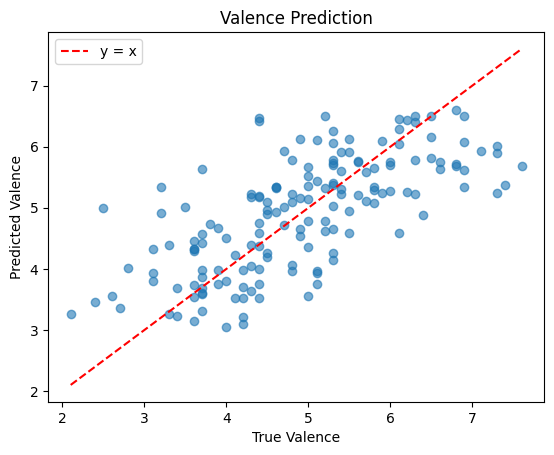

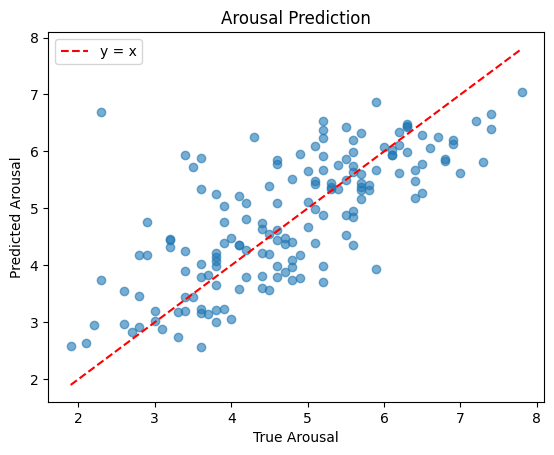

In [137]:

# Plot Valence
plt.figure()
plt.scatter(all_targets[:,0], all_preds[:,0], alpha=0.6)
xmin, xmax = all_targets[:,0].min(), all_targets[:,0].max()
plt.plot([xmin, xmax], [xmin, xmax], 'r--', label='y = x')
plt.xlabel("True Valence")
plt.ylabel("Predicted Valence")
plt.title("Valence Prediction")
plt.legend()
plt.show()

# Plot Arousal
plt.figure()
plt.scatter(all_targets[:,1], all_preds[:,1], alpha=0.6)
ymin, ymax = all_targets[:,1].min(), all_targets[:,1].max()
plt.plot([ymin, ymax], [ymin, ymax], 'r--', label='y = x')
plt.xlabel("True Arousal")
plt.ylabel("Predicted Arousal")
plt.title("Arousal Prediction")
plt.legend()
plt.show()


## Inference on a small batch

In [138]:
import random
import pandas as pd

# Reconstruct the list of song_ids in the same order of all_preds
ds = test_loader.dataset
if hasattr(ds, "indices"):
    # If a subset for your test split was used
    orig_ds = ds.dataset
    full_ids = orig_ds.ids
    ids_list = [ full_ids[i] for i in ds.indices ]
else:
    # dataset.ids is already just the test IDs, in order
    ids_list = ds.ids

# Now all_preds/all_targets are length N = len(ids_list)
N = len(all_preds)
k = 5

# Pick k random valid indices
sample_idxs = random.sample(range(N), k)

# Build your table directly from the arrays
rows = []
for i in sample_idxs:
    rows.append({
        "song_id"      : ids_list[i],
        "true_valence" : round(float(all_targets[i,0]), 2),
        "pred_valence" : round(float(all_preds[i,0]), 2),
        "true_arousal" : round(float(all_targets[i,1]), 2),
        "pred_arousal" : round(float(all_preds[i,1]), 2),
    })

df = pd.DataFrame(rows)
print(df.to_string(index=False))


 song_id  true_valence  pred_valence  true_arousal  pred_arousal
    1876           6.3          5.79           5.0          5.66
     352           5.5          4.58           4.5          4.20
    1271           4.6          4.93           4.7          4.49
    1846           5.8          5.34           5.8          5.31
    1461           5.3          5.02           4.2          4.81


#### Confusion Matrix

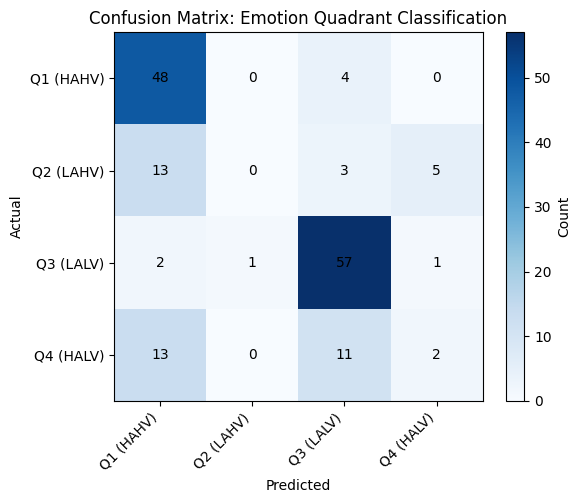

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

valence_pred = all_preds[:, 0]
valence_true = all_targets[:, 0]
arousal_pred = all_preds[:, 1]
arousal_true = all_targets[:, 1]

# Quadrant assignment
def get_quadrant(v, a, threshold=5.0):
    if v >= threshold and a >= threshold:
        return 0  # Q1: High Valence, High Arousal (HAVH)
    elif v < threshold and a >= threshold:
        return 1  # Q2: Low Valence, High Arousal (LAVH)
    elif v < threshold and a < threshold:
        return 2  # Q3: Low Valence, Low Arousal (LALV)
    else:
        return 3  # Q4: High Valence, Low Arousal (HALV)

# threshold is the same as in the data weighting - i.e. the mean
true_quads = [get_quadrant(v, a) for v, a in zip(valence_true, arousal_true)]
pred_quads = [get_quadrant(v, a) for v, a in zip(valence_pred, arousal_pred)]

# Compute confusion matrix
cm = confusion_matrix(true_quads, pred_quads)
labels = ['Q1 (HAHV)', 'Q2 (LAHV)', 'Q3 (LALV)', 'Q4 (HALV)']

# Plot with Matplotlib, using 'Blues' cmap to mimic seaborn
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

# Labels and title
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix: Emotion Quadrant Classification")

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count')

fig.tight_layout()
plt.show()


#### Valence-Arousal Scatter

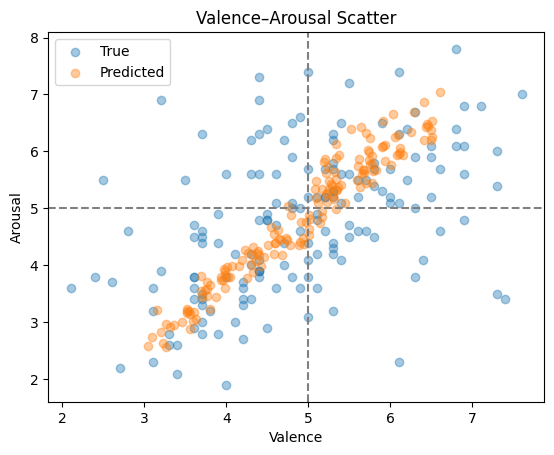

In [140]:
import matplotlib.pyplot as plt

plt.scatter(valence_true, arousal_true, alpha=0.4, label='True')
plt.scatter(valence_pred, arousal_pred, alpha=0.4, label='Predicted')
plt.axhline(5.0, color='gray', linestyle='--')
plt.axvline(5.0, color='gray', linestyle='--')
plt.legend()
plt.title("Valence–Arousal Scatter")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.show()

#### Loss vs. Epochs

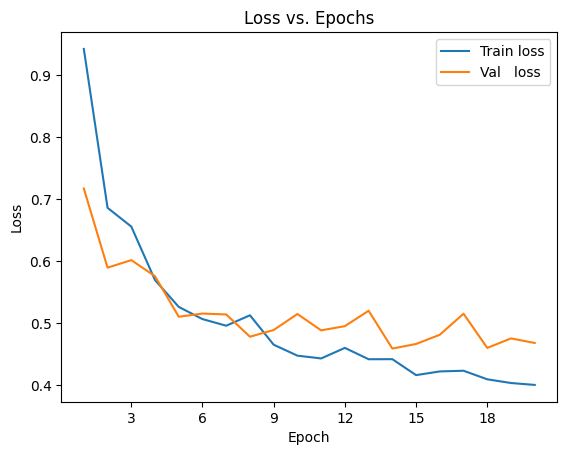

In [141]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

epochs = list(range(1, len(train_losses)+1))

fig, ax = plt.subplots()
ax.plot(epochs, train_losses, label="Train loss")
ax.plot(epochs, val_losses,   label="Val   loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Epochs")
ax.legend()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()


#### MSE vs. Epochs

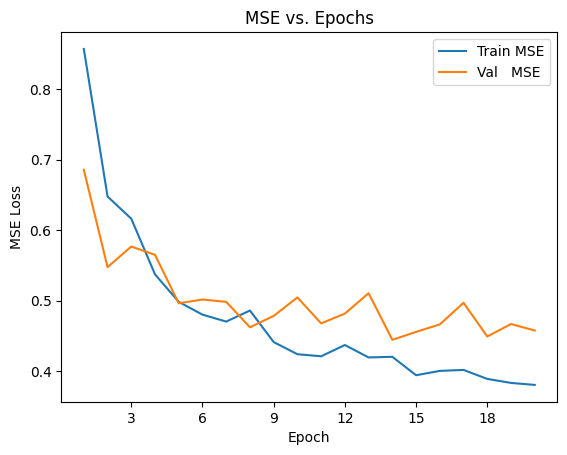

In [142]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

epochs = list(range(1, len(train_losses)+1))

fig, ax = plt.subplots()
ax.plot(epochs, train_mses, label="Train MSE")
ax.plot(epochs, val_mses,   label="Val   MSE")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("MSE vs. Epochs")
ax.legend()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()


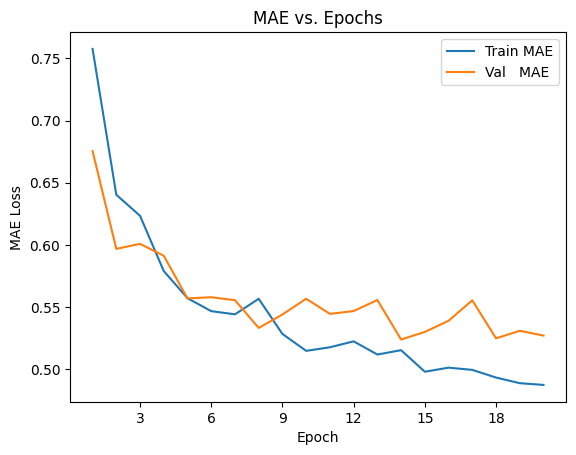

In [143]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

epochs = list(range(1, len(train_losses)+1))

fig, ax = plt.subplots()
ax.plot(epochs, train_maes, label="Train MAE")
ax.plot(epochs, val_maes,   label="Val   MAE")
ax.set_xlabel("Epoch")
ax.set_ylabel("MAE Loss")
ax.set_title("MAE vs. Epochs")
ax.legend()

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()


#### Plotting Distributions

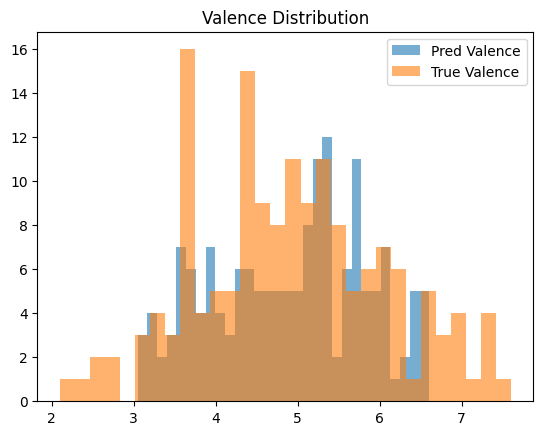

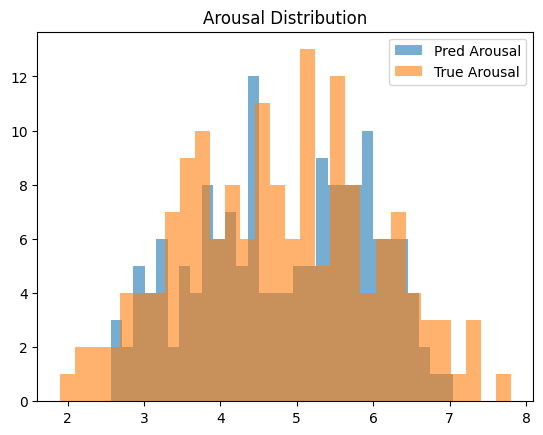

In [144]:
plt.hist(valence_pred, bins=30, alpha=0.6, label="Pred Valence")
plt.hist(valence_true, bins=30, alpha=0.6, label="True Valence")
plt.legend(); plt.title("Valence Distribution"); plt.show()

plt.hist(arousal_pred, bins=30, alpha=0.6, label="Pred Arousal")
plt.hist(arousal_true, bins=30, alpha=0.6, label="True Arousal")
plt.legend(); plt.title("Arousal Distribution"); plt.show()

#### Printing correlations

In [145]:
import numpy as np

# Prediction correlation
pred_corr = np.corrcoef(all_preds[:, 0], all_preds[:, 1])[0, 1]

# True data correlation
true_corr = np.corrcoef(all_targets[:, 0], all_targets[:, 1])[0, 1]

print(f"Prediction valence-arousal ρ = {pred_corr:.4f}")
print(f"Ground-truth valence-arousal ρ = {true_corr:.4f}")


Prediction valence-arousal ρ = 0.9702
Ground-truth valence-arousal ρ = 0.4961
